In [64]:
import ta
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


In [65]:
data = pd.read_csv("Data/aapl_5m_train.csv").dropna()

In [66]:
data.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume
0,0,1609770600,0,2021-01-04 14:30:00,133.570007,133.611602,132.389999,132.809997,6624663.0
1,1,1609770900,0,2021-01-04 14:35:00,132.750000,132.750000,131.809997,131.889999,2541553.0
2,2,1609771200,0,2021-01-04 14:40:00,131.500000,132.339996,131.500000,132.059997,2492415.0
3,3,1609771500,0,2021-01-04 14:45:00,132.000000,132.250000,131.899993,132.250000,1859131.0
4,4,1609771800,0,2021-01-04 14:50:00,132.000000,132.018096,131.520004,131.589996,1780105.0


In [67]:
rsi_indicator = ta.momentum.RSIIndicator(data.Close, window=20)
data['rsi'] = rsi_indicator.rsi()

In [68]:
historic = data.dropna()
historic['buy_signal'] = historic.rsi < 20
historic['sell_signal'] = historic.rsi > 80

/var/folders/hp/74fh93z51nbgcfx2dccxw8w80000gn/T/ipykernel_79963/3384102837.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['buy_signal'] = historic.rsi < 20
/var/folders/hp/74fh93z51nbgcfx2dccxw8w80000gn/T/ipykernel_79963/3384102837.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  historic['sell_signal'] = historic.rsi > 80


In [69]:
historic.head()

,Unnamed: 0,Timestamp,Gmtoffset,Datetime,Open,High,Low,Close,Volume,rsi,buy_signal,sell_signal
19,19,1609776300,0,2021-01-04 16:05:00,130.309997,130.549896,129.660003,129.866699,3030766.0,26.683236,False,False
20,20,1609776600,0,2021-01-04 16:10:00,129.860000,130.239898,129.399993,130.089996,2231137.0,30.749593,False,False
21,21,1609776900,0,2021-01-04 16:15:00,130.080093,130.354995,129.904602,130.324996,1328068.0,34.758166,False,False
22,22,1609777200,0,2021-01-04 16:20:00,130.324005,130.419998,129.930099,129.996398,1233893.0,32.029264,False,False
23,23,1609777500,0,2021-01-04 16:25:00,129.994995,130.206695,129.880004,129.895004,1144809.0,31.232801,False,False


In [70]:
from dataclasses import dataclass

@dataclass
class Operation:
    time: str
    price: float
    stop_loss: float
    take_profit: float
    n_shares: int
    type: str

In [71]:
def get_portfolio_value(cash: float, long_ops: list[Operation],
                        short_ops: list[Operation], current_price: float,
                        n_shares: int) -> float:
    val = cash
    
    #  Add long positions value
    val += len(long_ops) * current_price * n_shares

    # TODO: Add short positions value
    return val

In [72]:
COM = 0.125 / 100
SL = 0.1
TP = 0.1
BORROW_RATE = 0.25/100

cash = 1_000_000
n_shares = 200

active_long_positions: list[Operation] = []

portfolio_value = [cash]

for i, row in historic.iterrows():
    #This only works for long positions
    portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))
    portfolio_value.append(cash + len(active_long_positions) * row.Close * n_shares)
    # Close positions
    for position in active_long_positions.copy():
        if row.Close > position.take_profit or row.Close < position.stop_loss:
            cash += row.Close * position.n_shares * (1 - COM)
            active_long_positions.remove(position)

    # --- BUY ---
    # Chek signal
    if not row.buy_signal:
        continue
    
         # Do we have enough cash?

    if cash < row.Close * n_shares * (1 + COM):
        continue

    # Discount the cost
    cash -= row.Close * n_shares * (1 + COM)
    #Save the operation as active position

    active_long_positions.append(
        Operation(
            time = row.Datetime,
            price = row.Close,
            take_profit = row.Close * (1 + TP),
            stop_loss=row.Close * (1 - SL),
            n_shares = n_shares,
            type = "LONG"
        )
    )

cash += row.Close * len(active_long_positions) * n_shares * (1 - COM)        
active_long_positions = []

In [73]:
COM = 0.125 / 100
SL = 0.05
TP = 0.05
BORROW_RATE = 0.25/100

cash = 1_000_000
n_shares = 50


active_long_positions= []

portfolio_value = [cash]

for i, row in historic.iterrows():
    
    # This only works for long positions
    portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))


    # Close Operations
    for position in active_long_positions.copy():
        if row.Close > position.take_profit or row.Close < position.stop_loss:
            cash += row.Close * position.n_shares * (1 - COM)
            active_long_positions.remove(position)

    # --- BUY
    # Check Signal
    if not row.buy_signal:
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

        continue

    # Enough Cash?
    if cash < row.Close * n_shares * (1 + COM):
        portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

        continue
    # Discount Costs
    cash -= row.Close * n_shares * (1 + COM)


    # Save the Operation as active position
    active_long_positions.append(
        Operation(
        time=row.Datetime,
        price=row.Close,
        take_profit=row.Close * (1 + TP),
        stop_loss= row.Close * (1 - SL),
        n_shares=n_shares,
        type = "LONG"
    )
)

    portfolio_value.append(get_portfolio_value(cash, active_long_positions, [], row.Close, n_shares))

#añadimos al cash las posiciones que siguen abiertas cuando terminamos las posiciones

cash += row.Close * len(active_long_positions) *(1 - COM)
active_position = []

In [74]:
cash, len(active_long_positions)

(1007816.8160896875, 0)

<Axes: >

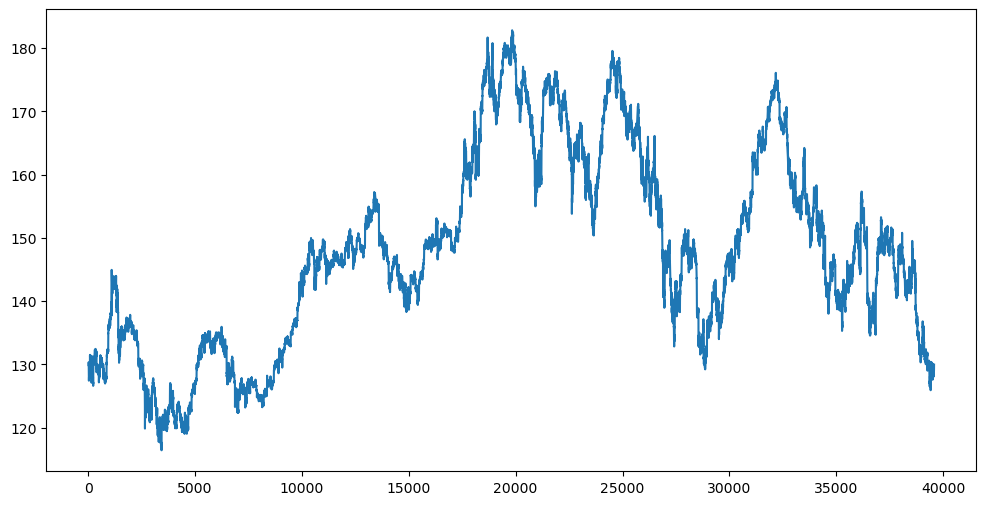

In [75]:
historic['Close'].plot(figsize=(12,6))